# Classification Project

Why are our customers churning?

Some questions I have include:

- Could the month in which they signed up influence churn? i.e. if a cohort is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts? (Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers))
- Are there features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?
- Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?
- If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

Deliverables:

1. I will also need a report (ipynb) answering the question, "Why are our customers churning?" I want to see the analysis you did to answer my questions and lead to your findings. Please clearly call out the questions and answers you are analyzing. E.g. If you find that month-to-month customers churn more, I won't be surprised, but I am not getting rid of that plan. The fact that they churn is not because they can, it's because they can and they are motivated to do so. I want some insight into why they are motivated to do so. I realize you will not be able to do a full causal experiment, but I hope to see some solid evidence of your conclusions.

2. I will need you to deliver to me a csv with the customer_id, probability of churn, and the prediction of churn (1=churn, 0=not_churn). I would also like a single google slide that illustrates how your model works, including the features being used, so that I can deliver this to the SLT (senior leadership team) when they come with questions about how these values were derived. Please make sure you include how likely your model is to give a high probability of churn when churn doesn't occur, to give a low probability of churn when churn occurs, and to accurately predict churn.

3. Finally, our development team will need a .py file that will take in a new dataset, (in the exact same form of the one you acquired from telco_churn.customers) and perform all the transformations necessary to run the model you have developed on this new dataset to provide probabilities and predictions.

## Specification

Detailed instructions for each section are below.

In general, make sure you document your work. You don't need to explain what every line of code is doing, but you should explain what and why you are doing. For example, if you drop a feature from the dataset, you should explain why you decided to do so, or why that is a reasonable thing to do. If you transform the data in a column, you should explain why you are making that transformation.

In addition, you should not present numbers in isolation. If your code outputs a number, be sure you give some context to the number.

Specific Deliverables:

- a jupyter notebook where your work takes place
- a csv file that predicts churn for each customer
a python script that prepares data such that it can be fed into your model
- a google slide summarizing your model
- a README.md file that contains a link to your google slides presentation, and instructions for how to use your python script(s)

In [1]:
#import modules

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pydataset import data
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support as pfs
import sklearn.metrics as skm
import graphviz
from graphviz import Graph
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import math as m
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import io
import env

In [2]:
def df_print_missing_vals(df):
    # any missing values?
    # prints the number of missing values 
    # only for columns with missing values
    print("\nMissing Values:\n")
    null_counts = df.isnull().sum()
    if len(null_counts[null_counts > 0]) == 0:
        print("No missing values")
    else:
        print(null_counts[null_counts > 0])


def df_percent_missing_vals(df):
    return (df.isnull().sum() / df.shape[0]) * 100

def df_metadata(df) -> tuple:
    """
    return a tuple of (size, shape, info)
    """
    buffer = io.StringIO()
    df.info(buf=buffer)
    return (df.size, df.shape, buffer.getvalue())

def df_print_metadata(df) -> None:
    """
    print metadata of dataframe
    """
    size, shape, info = df_metadata(df)
    print("DATAFRAME METADATA")
    print(f"Size: {size}")
    print()
    print(f"Shape: {shape[0]} x {shape[1]}")
    print()
    print("Info:")
    print(info, end="")
    df_print_missing_vals(df)
    print("Percentages of Missing Values are:")
    print(df_percent_missing_vals(df))
    
def df_print_r_and_p_values(X, y):
    r_and_p_values = {col: stats.pearsonr(X[col], y) for col in X.columns}
    print("PEARSON'S R")
    for k, v in r_and_p_values.items():
        col = k
        r, p = v
        print(f"{col}:")
        print(f"\tPearson's R is {r:.2f} ")
        print(f"\twith a significance p-value of {p: .3}\n")

### Acquisition
1. Get the data from the customers table from the telco_churn database on the codeup data science database server.
    - You may wish to join some tables as part of your query.
    - This data should end up in a pandas data frame.

#### Importing the data directly from Mysql.

In [3]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [4]:
dbc = get_connection('telco_churn')
telco_full = pd.read_sql('SELECT * FROM customers c JOIN contract_types ct\
                            ON c.contract_type_id = ct.contract_type_id JOIN internet_service_types it\
                            ON c.internet_service_type_id = it.internet_service_type_id JOIN payment_types pt\
                            ON c.payment_type_id = pt.payment_type_id', dbc)
telco_full.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,payment_type_id,monthly_charges,total_charges,churn,contract_type_id,contract_type,internet_service_type_id,internet_service_type,payment_type_id,payment_type
0,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,...,2,59.9,542.4,No,1,Month-to-month,1,DSL,2,Mailed check
1,0013-MHZWF,Female,0,No,Yes,9,Yes,No,1,No,...,4,69.4,571.45,No,1,Month-to-month,1,DSL,4,Credit card (automatic)
2,0015-UOCOJ,Female,1,No,No,7,Yes,No,1,Yes,...,1,48.2,340.35,No,1,Month-to-month,1,DSL,1,Electronic check
3,0023-HGHWL,Male,1,No,No,1,No,No phone service,1,No,...,1,25.1,25.1,Yes,1,Month-to-month,1,DSL,1,Electronic check
4,0032-PGELS,Female,0,Yes,Yes,1,No,No phone service,1,Yes,...,3,30.5,30.5,Yes,1,Month-to-month,1,DSL,3,Bank transfer (automatic)


#### Importing data from csv file

In [5]:
df = pd.read_csv('telco_full_data.csv')
df.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'internet_service_type_id',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract_type_id',
       'paperless_billing', 'payment_type_id', 'monthly_charges',
       'total_charges', 'churn', 'contract_type_id.1', 'contract_type',
       'internet_service_type_id.1', 'internet_service_type',
       'payment_type_id.1', 'payment_type'],
      dtype='object')

In [6]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,payment_type_id,monthly_charges,total_charges,churn,contract_type_id.1,contract_type,internet_service_type_id.1,internet_service_type,payment_type_id.1,payment_type
0,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,...,2,59.9,542.4,No,1,Month-to-month,1,DSL,2,Mailed check
1,0013-MHZWF,Female,0,No,Yes,9,Yes,No,1,No,...,4,69.4,571.45,No,1,Month-to-month,1,DSL,4,Credit card (automatic)
2,0015-UOCOJ,Female,1,No,No,7,Yes,No,1,Yes,...,1,48.2,340.35,No,1,Month-to-month,1,DSL,1,Electronic check
3,0023-HGHWL,Male,1,No,No,1,No,No phone service,1,No,...,1,25.1,25.1,Yes,1,Month-to-month,1,DSL,1,Electronic check
4,0032-PGELS,Female,0,Yes,Yes,1,No,No phone service,1,Yes,...,3,30.5,30.5,Yes,1,Month-to-month,1,DSL,3,Bank transfer (automatic)


#### Checking that duplicate columns are the same. (they are)

In [7]:
df.loc[df['payment_type_id'] != df['payment_type_id.1']]
df.loc[df['contract_type_id'] != df['contract_type_id.1']]
df.loc[df['internet_service_type_id'] != df['internet_service_type_id.1']]

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,payment_type_id,monthly_charges,total_charges,churn,contract_type_id.1,contract_type,internet_service_type_id.1,internet_service_type,payment_type_id.1,payment_type


#### Dropping duplicate columns

In [8]:
df.drop(['payment_type_id.1', 'contract_type_id.1', 'internet_service_type_id.1'], inplace=True, axis=1)

In [9]:
df.sample(5)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
6916,8007-YYPWD,Female,0,No,No,15,Yes,Yes,3,No internet service,...,No internet service,3,No,3,25.05,369.1,No,Two year,None,Bank transfer (automatic)
5260,4057-FKCZK,Male,0,Yes,Yes,58,Yes,Yes,2,No,...,No,3,No,3,82.50,4828.05,No,Two year,Fiber optic,Bank transfer (automatic)
2509,0396-YCHWO,Male,0,Yes,No,36,Yes,Yes,2,No,...,Yes,1,Yes,1,95.40,3474.2,No,Month-to-month,Fiber optic,Electronic check
3221,3717-OEAUQ,Male,0,No,No,2,Yes,No,2,No,...,No,1,No,2,70.70,129.2,No,Month-to-month,Fiber optic,Mailed check
2518,0432-CAJZV,Male,0,No,No,3,Yes,No,2,No,...,Yes,1,No,2,90.70,237.65,No,Month-to-month,Fiber optic,Mailed check


In [10]:
df.tech_support.unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [11]:
df.device_protection.unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [12]:
df_print_missing_vals(df)


Missing Values:

No missing values


In [13]:
df_percent_missing_vals(df)

customer_id                 0.0
gender                      0.0
senior_citizen              0.0
partner                     0.0
dependents                  0.0
tenure                      0.0
phone_service               0.0
multiple_lines              0.0
internet_service_type_id    0.0
online_security             0.0
online_backup               0.0
device_protection           0.0
tech_support                0.0
streaming_tv                0.0
streaming_movies            0.0
contract_type_id            0.0
paperless_billing           0.0
payment_type_id             0.0
monthly_charges             0.0
total_charges               0.0
churn                       0.0
contract_type               0.0
internet_service_type       0.0
payment_type                0.0
dtype: float64

### Data Dictionary
- gender: is the customer male or female?
- senior_citizen: is the customer a senior citizen? 1 for yes, 0 for no.
- partner: does the customer have a partner?
- dependents: does the customer have dependents?
- tenure: Number of months the customer has had one of our services. 0 would mean they haven't been with us a full month yet.
- phone_service: does the customer have phone service?
- multiple_lines: does the customer have multiple lines? yes, no, or no phone service.
- internet_service_type_id: id of type of internet service.
- online_security: does the customer utilize the option of having a password.
- online_backup: does the customer utilize the option to backup their files?
- device_protection: does the customer utilize the option to protect their internet device (i.e. router)?
- tech_support: does the customer utilize the option to talk to tech support?
- streaming_tv: does the customer have the tv streaming service?
- streaming_movies: does the customer have the movie streaming service?
- contract_type_id: id of type of contract.
- paperless_billing: customer using paperless billing option?
- payment_type_id: id of type of payment.
- monthly_charges: Most recent monthly charge for that customer.
- total_charges: Most recent total charges for that customer.
- churn: Did the customer churn?
- contract_type: type of contract.
- internet_service_type: type of internet service.
- payment_type: type of payment.

### Hypothesis/General Ideas
- I believe that customers with multiple lines will have a decent effect on whether a customer churns or not. A customer with multiple lines might be less inclined to churn due to having to move all the lines over. Likewise, those with streaming services will be less likely to churn. Basically, the more services a customer has the less likely to churn.
- Monthly charges will also play a role. The more a customer pays, the more likely to churn.

2. Write a function, peekatdata(dataframe), that takes a dataframe as input and computes and returns the following:
    - creates dataframe object head_df (df of the first 5 rows) and prints contents to screen
    - creates dataframe object tail_df (df of the last 5 rows) and prints contents to screen
    - creates tuple object shape_tuple (tuple of (nrows, ncols)) and prints tuple to screen
    - creates dataframe object describe_df (summary statistics of all numeric variables) and prints contents to screen.
    - prints to screen the information about a DataFrame including the index dtype and column dtypes, non-null values and memory usage.

In [14]:
def peekatdata(df):
    print('First five rows of the dataframe:')
    head_df = df.head()
    print(head_df)
    print('\n')
    print('Last five rows of the dataframe:')
    tail_df = df.tail()
    print(tail_df)
    print('\n')
    print('Shape of the dataframe:')
    shape_tuple = df.shape
    print(shape_tuple)
    print('\n')
    print('Describe dataframe:')
    describe_df = df.describe()
    print(describe_df)
    print('\n')
    print('Data types of each column:')
    print(df.dtypes)
    print('\n')
    print('Non-nulls in each column:')
    print(df.info())
    print('\n')
    print('Memory usage:')
    print(df.memory_usage)

peekatdata(df)

First five rows of the dataframe:
  customer_id  gender  senior_citizen partner dependents  tenure  \
0  0003-MKNFE    Male               0      No         No       9   
1  0013-MHZWF  Female               0      No        Yes       9   
2  0015-UOCOJ  Female               1      No         No       7   
3  0023-HGHWL    Male               1      No         No       1   
4  0032-PGELS  Female               0     Yes        Yes       1   

  phone_service    multiple_lines  internet_service_type_id online_security  \
0           Yes               Yes                         1              No   
1           Yes                No                         1              No   
2           Yes                No                         1             Yes   
3            No  No phone service                         1              No   
4            No  No phone service                         1             Yes   

             ...             streaming_movies contract_type_id  \
0            ...

### Data Prep
1. Write a function, df_value_counts(dataframe), that takes a dataframe as input and computes and returns the values by frequency for each column. The function should decide whether or not to bin the data for the value counts.


2. Handle Missing Values
    - Explore the data and see if there are any missing values.
    
    Write a function that accepts a dataframe and returns the names of the columns that have missing values, and the percent of missing values in each column that has missing values.

    - Document your takeaways. For each variable:

        - should you remove the observations with a missing value for that variable?
        - should you remove the variable altogether?
        - is missing equivalent to 0 (or some other constant value) in the specific case of this variable?
        - should you replace the missing values with a value it is most likely to represent (e.g. Are the missing values a result of data integrity issues and should be replaced by the most likely value?)
        
    - Handle the missing values in the way you recommended above.

3. Transform churn such that "yes" = 1 and "no" = 0

4. Compute a new feature, tenure_year, that is a result of translating tenure from months to years.

5. Figure out a way to capture the information contained in phone_service and multiple_lines into a single variable of dtype int. Write a function that will transform the data and place in a new column named phone_id.

6. Figure out a way to capture the information contained in dependents and partner into a single variable of dtype int. Transform the data and place in a new column household_type_id.

7. Figure out a way to capture the information contained in streaming_tv and streaming_movies into a single variable of dtype int. Transform the data and place in a new column streaming_services.

8. Figure out a way to capture the information contained in online_security and online_backup into a single variable of dtype int. Transform the data and place in a new column online_security_backup.

9. Split the data into train (70%) & test (30%) samples.

10. Variable Encoding: encode the values in each non-numeric feature such that they are numeric.

11. Numeric Scaling: scale the monthly_charges and total_charges data. Make sure that the parameters for scaling are learned from the training data set.

### Data Exploration
1. Could the month in which they signed up influence churn? i.e. if a cohort is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts? (Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers)).

2. Are there features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?

3. Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?

4. If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

5. Controlling for services (phone_id, internet_service_type_id, online_security_backup, device_protection, tech_support, and contract_type_id), is the mean monthly_charges of those who have churned significantly different from that of those who have not churned? (Use a t-test to answer this.)

6. How much of monthly_charges can be explained by internet_service_type? (hint: correlation test). State your hypotheses and your conclusion clearly.

7. How much of monthly_charges can be explained by internet_service_type + phone service type (0, 1, or multiple lines). State your hypotheses and your conclusion clearly.

8. Create visualizations exploring the interactions of variables (independent with independent and independent with dependent). The goal is to identify features that are related to churn, identify any data integrity issues, understand 'how the data works'. For example, we may find that all who have online services also have device protection. In that case, we don't need both of those. (The visualizations done in your analysis for questions 1-5 count towards the requirements below)

    - Each independent variable (except for customer_id) should be visualized in at least two plots, and at least 1 of those compares the independent variable with the dependent variable.

    - For each plot where x and y are independent variables, add a third dimension (where possible), of churn represented by color.

    - Use subplots when plotting the same type of chart but with different variables.

    - Adjust the axes as necessary to extract information from the visualizations (adjusting the x & y limits, setting the scale where needed, etc.)

    - Add annotations to at least 5 plots with a key takeaway from that plot.

    - Use plots from matplotlib, pandas and seaborn.

    - Use each of the following:

        - sns.heatmap
        - pd.crosstab (along with sns.heatmap)
        - pd.scatter_matrix
        - sns.barplot
        - sns.swarmplot
        - sns.pairplot
        - sns.jointplot
        - sns.relplot or plt.scatter
        - sns.distplot or plt.hist
        - sns.boxplot
        - plt.plot
    - Use at least one more type of plot that is not included in the list above.

9. What can you say about each variable's relationship to churn, based on your initial exploration? If there appears to be some sort of interaction or correlation, assume there is no causal relationship and brainstorm (and document) ideas on reasons there could be correlation.

10. Summarize your conclusions, provide clear answers to the specific questions, and summarize any takeaways/action plan from the work above.

- phone_service: does the customer have phone service?
    - yes
    - no
- multiple_lines: does the customer have multiple lines? 
    - yes
    - no
    - no phone service.
- internet_service_type_id: id of type of internet service.
    - 1 = DSL
    - 2 = Fiber Optic
    - 3 = none

In [15]:
# take only the relevant columns DF
colnames = ['phone_service', 'multiple_lines', 'internet_service_type_id','contract_type', 'churn']
df_lines = df[colnames]

In [16]:
df_lines.contract_type.unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [17]:
df_lines.contract_type = [x.strip().replace(" ", "_") for x in df_lines.contract_type]

In [18]:
df_lines.contract_type.unique()

array(['Month-to-month', 'One_year', 'Two_year'], dtype=object)

In [19]:
def encode_yes_no_columns(df):
    cleanup_nums = {'phone_service':     {'Yes': 1, 'No': 0},
                    'multiple_lines': {'Yes': 1, 'No': 0, 'No phone service': 0},
                    'contract_type': {'Month-to-month': 0, 'One_year': 1, 'Two_year': 2},
                    'churn':  {'Yes': 1, 'No': 0}}

    df.replace(cleanup_nums, inplace=True)

In [20]:
encode_yes_no_columns(df_lines)
df_lines.sample(10)

,phone_service,multiple_lines,internet_service_type_id,contract_type,churn
6836,1,1,3,2,0
3544,1,1,2,0,1
3657,1,1,2,0,1
6119,1,0,3,1,0
1017,1,0,1,0,0
1247,1,1,1,1,0
916,1,0,1,0,0
6963,1,1,3,2,0
4832,1,0,2,1,0
4427,1,1,2,0,1


### Modeling
1. Feature Selection: Are there any variables that seem to provide limited to no additional information? If so, remove them.

2. Train (fit, transform, evaluate) multiple different models, varying the model type and your meta-parameters.

3. Compare evaluation metrics across all the models, and select the best performing model.

4. Test the final model (transform, evaluate) on your out-of-sample data (the testing data set). Summarize the performance. Interpret your results.

#### Check to see if phone_service, multiple_lines, and/or internet_service_type_id are possible drivers for churn.

In [21]:
df_print_metadata(df_lines)

DATAFRAME METADATA
Size: 35215

Shape: 7043 x 5

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
phone_service               7043 non-null int64
multiple_lines              7043 non-null int64
internet_service_type_id    7043 non-null int64
contract_type               7043 non-null int64
churn                       7043 non-null int64
dtypes: int64(5)
memory usage: 275.2 KB

Missing Values:

No missing values
Percentages of Missing Values are:
phone_service               0.0
multiple_lines              0.0
internet_service_type_id    0.0
contract_type               0.0
churn                       0.0
dtype: float64


In [22]:
# NOT HELPFUL AT ALL
# boxplot the variables
# plt.figure(figsize=(15, 30))
# for i, var in enumerate(colnames):
#     plt.subplot(4, 3, i + 1)
#     sns.boxplot(data=df_lines[var])
#     plt.xlabel(var)
#     #plt.yscale("log")
# plt.show()

In [23]:
# NOT HELPFUL AT ALL
# plt.figure(figsize=(15, 30))

# plt.subplot(221)
# numbins = np.arange(0, 1, 1)
# sns.distplot(df_lines.phone_service, bins=numbins, kde=False)

# plt.subplot(222)
# sns.distplot(df_lines.multiple_lines, bins=numbins, kde=False)

# plt.subplot(223)
# sns.distplot(df_lines.internet_service_type_id, bins=numbins, kde=False)

In [24]:
# adding in month-to-month column to compare month-to-month against
# one- and two-year contracts.
df_lines['monthly'] = (df_lines.contract_type == 0)
df_lines.loc[df_lines.monthly == True, 'monthly'] = 1
df_lines.loc[df_lines.monthly == False, 'monthly'] = 0
df_lines.head(3)

,phone_service,multiple_lines,internet_service_type_id,contract_type,churn,monthly
0,1,1,1,0,0,1
1,1,0,1,0,0,1
2,1,0,1,0,0,1


In [25]:
x_vars = ['phone_service', 'multiple_lines', 'internet_service_type_id', 'contract_type', 'monthly']

X_train, X_test, y_train, y_test = train_test_split(df_lines[x_vars], df_lines['churn'], train_size=0.8, random_state=123)
print('X_train.info():')
print(X_train.info())
print()
print('X_test.info():')
print(X_test.info())
print()
print('y_train.shape = ', y_train.shape)
print()
print('y_test.shape = ', y_test.shape)
print()

X_train.info():
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 6924 to 3582
Data columns (total 5 columns):
phone_service               5634 non-null int64
multiple_lines              5634 non-null int64
internet_service_type_id    5634 non-null int64
contract_type               5634 non-null int64
monthly                     5634 non-null int64
dtypes: int64(5)
memory usage: 264.1 KB
None

X_test.info():
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1409 entries, 941 to 3266
Data columns (total 5 columns):
phone_service               1409 non-null int64
multiple_lines              1409 non-null int64
internet_service_type_id    1409 non-null int64
contract_type               1409 non-null int64
monthly                     1409 non-null int64
dtypes: int64(5)
memory usage: 66.0 KB
None

y_train.shape =  (5634,)

y_test.shape =  (1409,)



In [26]:
X_train.describe()

,phone_service,multiple_lines,internet_service_type_id,contract_type,monthly
count,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000
mean,0.903443,0.421015,1.872559,0.689741,0.551118
std,0.295379,0.493766,0.735412,0.834170,0.497424
min,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,0.000000,2.000000,0.000000,1.000000
75%,1.000000,1.000000,2.000000,1.000000,1.000000
max,1.000000,1.000000,3.000000,2.000000,1.000000


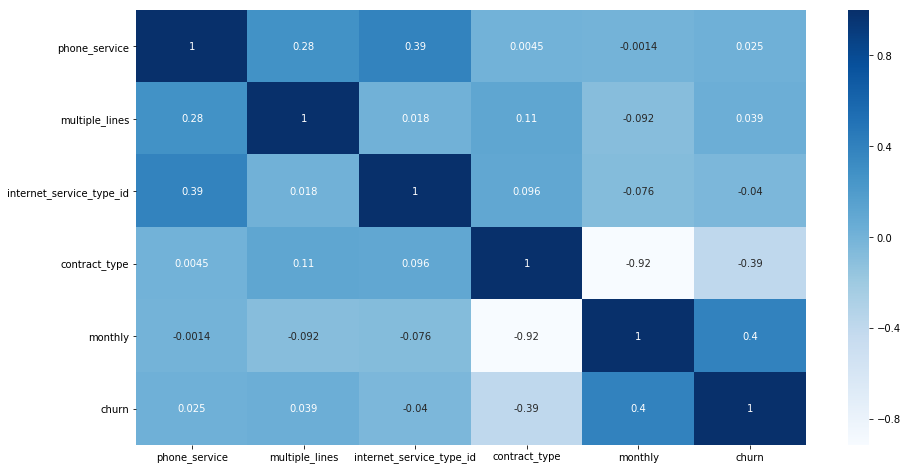

In [27]:
plt.figure(figsize=(15, 8))
sns.heatmap(pd.concat([X_train, y_train], axis=1).corr(), cmap="Blues", annot=True)
plt.show()

In [28]:
# Nothing interesting showing up here... 
df_print_r_and_p_values(X_train[x_vars], y_train)

PEARSON'S R
phone_service:
	Pearson's R is 0.03 
	with a significance p-value of  0.0598

multiple_lines:
	Pearson's R is 0.04 
	with a significance p-value of  0.00342

internet_service_type_id:
	Pearson's R is -0.04 
	with a significance p-value of  0.00277

contract_type:
	Pearson's R is -0.39 
	with a significance p-value of  1.06e-206

monthly:
	Pearson's R is 0.40 
	with a significance p-value of  2.68e-215



In [29]:
# Nothing interesting showing up here... 
for var in x_vars:
    print(f"vs. {var}")
    df_print_r_and_p_values(X_train[x_vars], X_train[var])

vs. phone_service
PEARSON'S R
phone_service:
	Pearson's R is 1.00 
	with a significance p-value of  0.0

multiple_lines:
	Pearson's R is 0.28 
	with a significance p-value of  4.36e-101

internet_service_type_id:
	Pearson's R is 0.39 
	with a significance p-value of  9.69e-202

contract_type:
	Pearson's R is 0.00 
	with a significance p-value of  0.737

monthly:
	Pearson's R is -0.00 
	with a significance p-value of  0.914

vs. multiple_lines
PEARSON'S R
phone_service:
	Pearson's R is 0.28 
	with a significance p-value of  4.36e-101

multiple_lines:
	Pearson's R is 1.00 
	with a significance p-value of  0.0

internet_service_type_id:
	Pearson's R is 0.02 
	with a significance p-value of  0.183

contract_type:
	Pearson's R is 0.11 
	with a significance p-value of  6.14e-18

monthly:
	Pearson's R is -0.09 
	with a significance p-value of  4.62e-12

vs. internet_service_type_id
PEARSON'S R
phone_service:
	Pearson's R is 0.39 
	with a significance p-value of  9.69e-202

multiple_lines:
	Pe

#### Is the churn rate significantly different for month-to-month contracts vs those with 2-year contracts?

In [30]:
df_train = pd.concat([X_train, y_train], axis=1)

# A t score of 28.7 means the group of two-year contracts is 
# 28.7 standard deviations from the mean of the group with 
# month-to-month contracts.

# - The larger the t statistic, the more difference there is between 
#   the groups, the more likely it is that the results are repeatable, 
#   i.e. that the difference is significant.

# - The smaller the score, the more similarity.

# So this shows that the month-to-month and 2-year contract groups are 
# significantly different from each other. So I need to group the number 
# of contracts with that aggragate. 

# Try various comparisons to see which are most significant.
month_to_month = df_train[df_train.contract_type == 0].churn
two_year = df_train[df_train.contract_type == 2].churn
print(stats.ttest_ind(month_to_month.values, two_year.values))

Ttest_indResult(statistic=28.653889190830636, pvalue=6.796094847922133e-166)


In [31]:
one_year = df_train[df_train.contract_type == 1].churn
print(stats.ttest_ind(month_to_month.values, one_year.values))

Ttest_indResult(statistic=19.856963153508357, pvalue=5.278934083224473e-84)


In [32]:
one_or_two_year = df_train[df_train.contract_type > 0].churn
print(stats.ttest_ind(month_to_month.values, one_or_two_year.values))

Ttest_indResult(statistic=32.733530159636985, pvalue=2.678733869411962e-215)


In [33]:
print(stats.ttest_ind(one_year.values, two_year.values))

Ttest_indResult(statistic=8.623632420161382, pvalue=1.1254185129583355e-17)


In [34]:
month_or_two = df_train[(df_train.contract_type == 0) | (df_train.contract_type == 2)].churn
print(stats.ttest_ind(one_year.values, month_or_two.values))

Ttest_indResult(statistic=-13.229828180018783, pvalue=2.2712467268607945e-39)


In [35]:
month_or_one = df_train[(df_train.contract_type == 0) | (df_train.contract_type == 1)].churn
print(stats.ttest_ind(two_year.values, month_or_one.values))

Ttest_indResult(statistic=-23.621996638838393, pvalue=1.0321416314849885e-117)


# So the month-to-month contracts are 32.7 standard deviations from the mean of the group with one- or two-year contracts.

### Try logistic regression on all independent variables

In [36]:
X_train.head(1)

,phone_service,multiple_lines,internet_service_type_id,contract_type,monthly
6924,1,1,3,2,0


In [37]:
y_train.head(1)

6924    0
Name: churn, dtype: int64

In [38]:
logit = LogisticRegression(C=1, class_weight={1:2}, random_state = 123, solver='saga')
print(logit.fit(X_train, y_train))
print('Coefficient: \n', logit.coef_)
print()
print('Intercept: \n', logit.intercept_)
y_pred = logit.predict(X_train)
y_pred_proba = logit.predict_proba(X_train)
X_train['prediction'] = logit.predict(X_train)

LogisticRegression(C=1, class_weight={1: 2}, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=123, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)
Coefficient: 
 [[ 0.12344084  0.45168402 -0.08282573 -1.49867688  0.27265229]]

Intercept: 
 [-0.02690154]


In [39]:
(y_train == X_train.prediction).sum() / y_train.shape[0]
# at 80% 0.6510472133475328
# at 75% 0.651836425596365
# at 50% 0.6557796080658904

0.6510472133475328

In [40]:
logit.score(X_train[['phone_service', 'multiple_lines', 'internet_service_type_id', 'contract_type', 'monthly']], y_train)

0.6510472133475328

In [41]:
confusion_df = pd.DataFrame(confusion_matrix(y_train, X_train.prediction),
             columns=['Pred -', 'Pred +'], index=['Actual -', 'Actual +'])

confusion_df

,Pred -,Pred +
Actual -,2356,1793
Actual +,173,1312


In [42]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.57      0.71      4149
           1       0.42      0.88      0.57      1485

   micro avg       0.65      0.65      0.65      5634
   macro avg       0.68      0.73      0.64      5634
weighted avg       0.80      0.65      0.67      5634



##### I was getting identical results when running with all the dependent variables as I did when running it with only the monthly column, so I tried changing the percentage of test/train split. My accuracy should have gone down, but it went slightly up. And the accuracies between the two models stayed identical. ????

#### Try logistic regression on only 
#### data grouped into month-to-month vs one or two-year contracts.

In [72]:
df_train.head(1)

,phone_service,multiple_lines,internet_service_type_id,contract_type,monthly,churn
6924,1,1,3,2,0,0


In [73]:
month_to_month = df_train[df_train.contract_type == 0].churn
one_or_two_year = df_train[df_train.contract_type > 0].churn
print(stats.ttest_ind(month_to_month.values, one_or_two_year.values))

Ttest_indResult(statistic=32.733530159636985, pvalue=2.678733869411962e-215)


In [74]:
X_train.head(3)

,phone_service,multiple_lines,internet_service_type_id,contract_type,monthly,prediction
6924,1,1,3,2,0,0
5249,1,0,2,2,0,0
5852,1,0,3,0,1,1


In [75]:
month_train = X_train[['monthly']]
month_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 6924 to 3582
Data columns (total 1 columns):
monthly    5634 non-null int64
dtypes: int64(1)
memory usage: 88.0 KB


In [80]:
month_train.head(3)

,monthly
6924,0
5249,0
5852,1


In [87]:
logit2 = LogisticRegression(C=1, class_weight={1:2}, random_state = 123, solver='saga')
print(logit2.fit(month_train, y_train))
print('Coefficient: \n', logit2.coef_)
print()
print('Intercept: \n', logit2.intercept_)

y_pred2 = logit2.predict(month_train)
y_pred_proba2 = logit2.predict_proba(month_train)
X_train['prediction'] = logit2.predict(month_train)

LogisticRegression(C=1, class_weight={1: 2}, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=123, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)
Coefficient: 
 [[2.28924896]]

Intercept: 
 [-1.91069478]


In [88]:
(y_train == X_train.prediction).sum() / y_train.shape[0]
# at 80% 0.6510472133475328
# at 75% 0.651836425596365
# at 50% 0.6557796080658904

0.6510472133475328

In [90]:
logit2.score(X_train[['monthly']], y_train)

0.6510472133475328

In [51]:
confusion_df = pd.DataFrame(confusion_matrix(y_train, X_train.prediction),
             columns=['Pred -', 'Pred +'], index=['Actual -', 'Actual +'])

confusion_df

,Pred -,Pred +
Actual -,2356,1793
Actual +,173,1312


In [52]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.57      0.71      4149
           1       0.42      0.88      0.57      1485

   micro avg       0.65      0.65      0.65      5634
   macro avg       0.68      0.73      0.64      5634
weighted avg       0.80      0.65      0.67      5634



#### The probabilities are identical, so checking another variable...
##### just phone_service against churn

In [53]:
X_train.head(3)

,phone_service,multiple_lines,internet_service_type_id,contract_type,monthly,prediction
6924,1,1,3,2,0,0
5249,1,0,2,2,0,0
5852,1,0,3,0,1,1


In [54]:
phone_train = X_train[['phone_service']]
phone_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 6924 to 3582
Data columns (total 1 columns):
phone_service    5634 non-null int64
dtypes: int64(1)
memory usage: 88.0 KB


In [55]:
logit = LogisticRegression(C=1, class_weight={1:2}, random_state = 123, solver='saga')
print(logit.fit(phone_train, y_train))
print('Coefficient: \n', logit.coef_)
print()
print('Intercept: \n', logit.intercept_)

y_pred = logit.predict(phone_train)
y_pred_proba = logit.predict_proba(phone_train)
X_train['prediction'] = logit.predict(phone_train)

LogisticRegression(C=1, class_weight={1: 2}, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=123, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)
Coefficient: 
 [[0.19925422]]

Intercept: 
 [-0.51519299]


In [56]:
(y_train == X_train.prediction).sum() / y_train.shape[0]
# at 80% 0.7364217252396166
# at 75% 0.7364634608102991
# at 50% 0.7384265833570008

0.7364217252396166

In [57]:
logit.score(X_train[['phone_service']], y_train)

0.7364217252396166

In [58]:
confusion_df = pd.DataFrame(confusion_matrix(y_train, X_train.prediction),
             columns=['Pred -', 'Pred +'], index=['Actual -', 'Actual +'])

confusion_df

,Pred -,Pred +
Actual -,4149,0
Actual +,1485,0


In [59]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85      4149
           1       0.00      0.00      0.00      1485

   micro avg       0.74      0.74      0.74      5634
   macro avg       0.37      0.50      0.42      5634
weighted avg       0.54      0.74      0.62      5634



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


##### The accuracy for a logistic regression including only phone_service was different, but it also got more accurate as I decreased the percentage of data that went to test. That should not happen. ????

##### Trying with each column now...
##### First,  just multiple_lines against churn

In [60]:
multiple_lines_train = X_train[['multiple_lines']]
print(multiple_lines_train.info())

logit = LogisticRegression(C=1, class_weight={1:2}, random_state = 123, solver='saga')
print(logit.fit(multiple_lines_train, y_train))
print('Coefficient: \n', logit.coef_)
print()
print('Intercept: \n', logit.intercept_)

y_pred = logit.predict(multiple_lines_train)
y_pred_proba = logit.predict_proba(multiple_lines_train)
X_train['prediction'] = logit.predict(multiple_lines_train)

(y_train == X_train.prediction).sum() / y_train.shape[0]
# at 80% 0.7364217252396166
# identical to using only phone!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 6924 to 3582
Data columns (total 1 columns):
multiple_lines    5634 non-null int64
dtypes: int64(1)
memory usage: 88.0 KB
None
LogisticRegression(C=1, class_weight={1: 2}, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=123, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)
Coefficient: 
 [[0.17787032]]

Intercept: 
 [-0.41101349]


0.7364217252396166

In [61]:
logit.score(X_train[['multiple_lines']], y_train)

0.7364217252396166

In [62]:
confusion_df = pd.DataFrame(confusion_matrix(y_train, X_train.prediction),
             columns=['Pred -', 'Pred +'], index=['Actual -', 'Actual +'])

confusion_df

,Pred -,Pred +
Actual -,4149,0
Actual +,1485,0


In [63]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85      4149
           1       0.00      0.00      0.00      1485

   micro avg       0.74      0.74      0.74      5634
   macro avg       0.37      0.50      0.42      5634
weighted avg       0.54      0.74      0.62      5634



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


##### just internet_service_type_id against churn

In [64]:
internet_service_type_id_train = X_train[['internet_service_type_id']]
print(internet_service_type_id_train.info())

logit = LogisticRegression(C=1, class_weight={1:2}, random_state = 123, solver='saga')
print(logit.fit(internet_service_type_id_train, y_train))
print('Coefficient: \n', logit.coef_)
print()
print('Intercept: \n', logit.intercept_)

y_pred = logit.predict(internet_service_type_id_train)
y_pred_proba = logit.predict_proba(internet_service_type_id_train)
X_train['prediction'] = logit.predict(internet_service_type_id_train)

(y_train == X_train.prediction).sum() / y_train.shape[0]
# at 80% 0.7364217252396166
# and again... identical to using only phone!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 6924 to 3582
Data columns (total 1 columns):
internet_service_type_id    5634 non-null int64
dtypes: int64(1)
memory usage: 88.0 KB
None
LogisticRegression(C=1, class_weight={1: 2}, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=123, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)
Coefficient: 
 [[-0.13834664]]

Intercept: 
 [-0.08051117]


0.7364217252396166

In [65]:
logit.score(X_train[['internet_service_type_id']], y_train)

0.7364217252396166

In [66]:
confusion_df = pd.DataFrame(confusion_matrix(y_train, X_train.prediction),
             columns=['Pred -', 'Pred +'], index=['Actual -', 'Actual +'])

confusion_df

,Pred -,Pred +
Actual -,4149,0
Actual +,1485,0


In [67]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85      4149
           1       0.00      0.00      0.00      1485

   micro avg       0.74      0.74      0.74      5634
   macro avg       0.37      0.50      0.42      5634
weighted avg       0.54      0.74      0.62      5634



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


##### just contract_type against churn

In [68]:
contract_type_train = X_train[['contract_type']]
print(contract_type_train.info())


logit = LogisticRegression(C=1, class_weight={1:2}, random_state = 123, solver='saga')
print(logit.fit(contract_type_train, y_train))
print('Coefficient: \n', logit.coef_)
print()
print('Intercept: \n', logit.intercept_)

y_pred = logit.predict(contract_type_train)
y_pred_proba = logit.predict_proba(contract_type_train)
X_train['prediction'] = logit.predict(contract_type_train)

(y_train == X_train.prediction).sum() / y_train.shape[0]
# at 80% 0.6510472133475328
# finally, a distinctly different accuracy rate!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 6924 to 3582
Data columns (total 1 columns):
contract_type    5634 non-null int64
dtypes: int64(1)
memory usage: 88.0 KB
None
LogisticRegression(C=1, class_weight={1: 2}, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=123, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)
Coefficient: 
 [[-1.65175055]]

Intercept: 
 [0.3723825]


0.6510472133475328

In [69]:
logit.score(X_train[['contract_type']], y_train)

0.6510472133475328

In [70]:
confusion_df = pd.DataFrame(confusion_matrix(y_train, X_train.prediction),
             columns=['Pred -', 'Pred +'], index=['Actual -', 'Actual +'])

confusion_df

,Pred -,Pred +
Actual -,2356,1793
Actual +,173,1312


In [71]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.57      0.71      4149
           1       0.42      0.88      0.57      1485

   micro avg       0.65      0.65      0.65      5634
   macro avg       0.68      0.73      0.64      5634
weighted avg       0.80      0.65      0.67      5634



#### Moving on to try Decision Tree

In [92]:
df.sample(3)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
604,4929-BSTRX,Female,0,No,No,1,Yes,No,1,No,...,No,1,Yes,2,53.55,53.55,Yes,Month-to-month,DSL,Mailed check
753,6133-OZILE,Female,0,No,No,18,No,No phone service,1,No,...,No,1,Yes,1,35.20,607.3,No,Month-to-month,DSL,Electronic check
3101,3174-RKMOW,Male,0,Yes,Yes,35,Yes,Yes,2,No,...,Yes,1,Yes,1,109.95,3782.4,No,Month-to-month,Fiber optic,Electronic check


In [112]:
# for classificaiton you can change the algorithm as gini or entropy 
# (information gain).  Default is gini.
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)

y_pred_proba = clf.predict_proba(X_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
cm = confusion_matrix(y_train, y_pred)

sorted(y_train.unique())
y_train.value_counts()

labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

print(classification_report(y_train, y_pred))
print()
print('y_train:')
print(y_train.head(3))
print()
print('y_pred:')
print([[y_pred]])
print()
print('X_test:')
print(X_test.head(3))
print()
print('y_test:')
print(y_test.head(3))
print()
clf.score(X_test, y_test)
# print('Accuracy of Decision Tree classifier on test set: {:.2f}'
#       .format(clf.score(X_test, y_test)))

#cm = pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)
#print(classification_report(y_train, y_pred))
#cm


Accuracy of Decision Tree classifier on training set: 0.76
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      4149
           1       0.54      0.62      0.58      1485

   micro avg       0.76      0.76      0.76      5634
   macro avg       0.70      0.72      0.70      5634
weighted avg       0.77      0.76      0.77      5634


y_train:
6924    0
5249    0
5852    1
Name: churn, dtype: int64

y_pred:
[[array([0, 0, 0, ..., 0, 1, 1])]]

X_test:
      phone_service  multiple_lines  internet_service_type_id  contract_type  \
941               1               0                         1              0   
1404              1               0                         1              1   
5515              1               1                         2              2   

      monthly  
941         1  
1404        0  
5515        0  

y_test:
941     0
1404    0
5515    0
Name: churn, dtype: int64



ValueError: Number of features of the model must match the input. Model n_features is 6 and input n_features is 5 